# GaussianNB Model

#### Dataset Information
No. of Features: 12  
No. of Instances: 4492 (one-minute interval) 

### Table of Contents<a name='table of contents'></a>

1. [Data Ingestion](#data ingestion)
2. [Features & Target Arrays](#features and target arrays)
3. [GaussianNB](#naive bayes)  
    a. [Classification Report](#classification report)  
    b. [Confusion Matrix](#confusion matrix)  
    c. [Class Balance Plot](#class balance)  
4. [Save Model](#pickle)

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import yellowbrick as yb
import seaborn as sns
sns.set_palette('RdBu', 10)

### Data Ingestion<a name='data ingestion'></a>

In [2]:
URL = 'https://raw.githubusercontent.com/georgetown-analytics/classroom-occupancy/master/models/sensor_data_ml.csv'

def fetch_data(fname='sensor_data_ml.csv'):
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Defining fetching data from the URL
DATA = fetch_data()

In [3]:
# Import as pandas dataframe with DateTimeIndex: df
df = pd.read_csv('sensor_data_ml.csv', index_col='datetime', parse_dates=True)

In [4]:
# Rename columns
df.columns = ['temp', 'humidity', 'co2', 'light', 'light_st', 'noise',
              'bluetooth', 'images', 'door', 'occupancy_count', 'occupancy_level']

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4492 entries, 2017-03-25 09:05:00 to 2017-06-10 16:47:00
Data columns (total 11 columns):
temp               4492 non-null float64
humidity           4492 non-null float64
co2                4492 non-null float64
light              4492 non-null float64
light_st           4492 non-null float64
noise              4492 non-null float64
bluetooth          4492 non-null float64
images             4492 non-null float64
door               4492 non-null float64
occupancy_count    4492 non-null float64
occupancy_level    4492 non-null object
dtypes: float64(10), object(1)
memory usage: 421.1+ KB


,temp,humidity,co2,light,light_st,noise,bluetooth,images,door,occupancy_count,occupancy_level
datetime,,,,,,,,,,,
2017-03-25 09:05:00,22.600000,36.900000,781.000000,430.000000,1.0,511.000000,1.000000,15.242697,0.000000,0.000000,empty
2017-03-25 09:06:00,23.800000,38.954167,765.465279,428.533744,1.0,503.515931,11.399457,15.242697,0.000000,0.000000,empty
2017-03-25 09:07:00,23.850000,38.900000,768.458333,423.576500,1.0,510.548913,19.916667,15.242697,0.083333,4.416667,low
2017-03-25 09:08:00,23.900000,38.766667,777.791667,423.053571,1.0,506.504630,29.750000,15.242697,0.000000,23.416667,mid-level
2017-03-25 09:09:00,23.908333,38.733333,770.864583,438.607904,1.0,500.092672,35.860577,15.242697,0.000000,30.000000,high


### Features & Target Arrays<a name='features and target arrays'></a>

In [6]:
# Breakdown of classroom occupancy levels
df.occupancy_level.value_counts()

high         2881
mid-level     781
empty         482
low           348
Name: occupancy_level, dtype: int64

In [7]:
# Encode multiclass target variable
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit_transform(df['occupancy_level'])

array([0, 0, 2, ..., 2, 2, 2], dtype=int64)

In [8]:
X = df.drop('occupancy_level', axis=1).values
y = df['occupancy_level']

In [9]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=12)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### GaussianNB Model<a name='naive bayes'></a>

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Fit GaussianNB classifier onto the training data: bayes
bayes = GaussianNB().fit(X_train, y_train)

cv_scores = cross_val_score(bayes, X_train, y_train, cv=tscv)

print('GaussianNB Cross-Validation Scores')
print(cv_scores)
print('Average 12-Fold CV Score: {:.4f}'.format(np.mean(cv_scores)))

GaussianNB Cross-Validation Scores
[ 0.85893417  0.89968652  0.88401254  0.9184953   0.66144201  0.10658307
  0.90909091  0.96238245  0.87460815  0.77115987  0.8369906   0.98432602]
Average 12-Fold CV Score: 0.8056


#### Classification Report<a name='classification report'></a>

In [11]:
from sklearn.metrics import classification_report

# Predict test set labels: y_pred
y_pred = bayes.predict(X_test)

print('Naive Bayes Classification Report')
print(classification_report(y_test, y_pred))
print('Training set score: {:.4f}'.format(bayes.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(bayes.score(X_test, y_test)))

Naive Bayes Classification Report
             precision    recall  f1-score   support

      empty       1.00      1.00      1.00        61
       high       0.99      0.99      0.99       198
        low       0.95      1.00      0.98        41
  mid-level       0.95      0.91      0.93        45

avg / total       0.98      0.98      0.98       345

Training set score: 0.9619
Test set score: 0.9826


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('F1 Score: {:.4f}'.format(f1_score(y_test, y_pred, average='micro')))
print('F1 Score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
print('F1 Score: {:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

F1 Score: 0.9826
F1 Score: 0.9825
F1 Score: 0.9745


In [13]:
print('Micro')
print('F1 Score: {:.4f}'.format(f1_score(y_test, y_pred, average='micro')))
print('Precision Score: {:.4f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Recall Score: {:.4f}'.format(recall_score(y_test, y_pred, average='micro')))

Micro
F1 Score: 0.9826
Precision Score: 0.9826
Recall Score: 0.9826


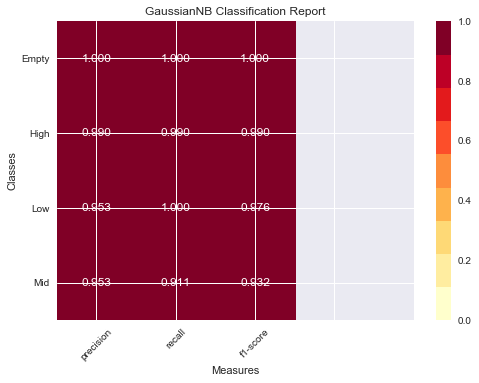

In [14]:
from yellowbrick.classifier import ClassificationReport

classes = ['Empty', 'High', 'Low', 'Mid']

fig = plt.figure()
visualizer = ClassificationReport(bayes, classes=classes)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
fig.savefig('ml_graphs/bayes_classification_report.png')

#### Confusion Matrix <a name='confusion matrix'></a>

In [15]:
from sklearn.metrics import confusion_matrix

print('Naive Bayes Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Naive Bayes Confusion Matrix
[[ 61   0   0   0]
 [  0 196   0   2]
 [  0   0  41   0]
 [  0   2   2  41]]


trying
trying
trying
trying
trying
trying
trying
trying
trying
trying


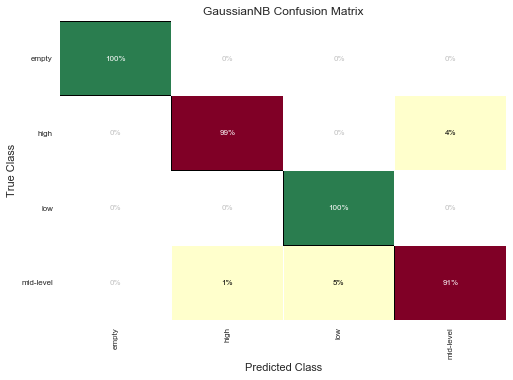

In [16]:
from yellowbrick.classifier import ConfusionMatrix

fig = plt.figure()
cm = ConfusionMatrix(bayes)
cm.score(X_test, y_test)
cm.poof()
fig.savefig('logreg_confusion_matrix.png')

#### Class Balance<a name='class balance'></a>

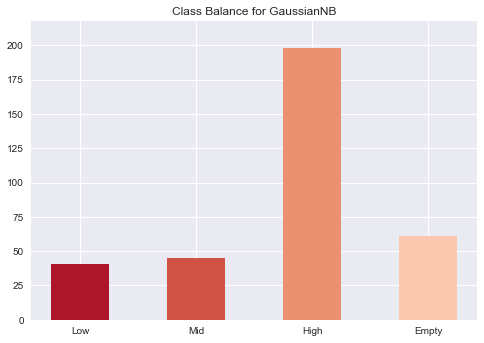

In [17]:
from yellowbrick.classifier import ClassBalance

fig = plt.figure()
visualizer = ClassBalance(bayes, classes=classes)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
fig.savefig('ml_graphs/bayes_class_balance.png')

### Save Model<a name='pickle'></a>

In [18]:
import pickle

bayes_model = 'bayes_model.sav'

# Save fitted model to disk
pickle.dump(bayes, open(bayes_model, 'wb'))

### [Return to Table of Contents](#table of contents)

In [19]:
loaded_model = pickle.load(open(bayes_model, 'rb'))

result = loaded_model.score(X_test, y_test)
print(result)

0.982608695652
